In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credential/Reddit credential.txt


In [2]:
import requests
import json
from IPython.display import JSON
from datetime import datetime

In [3]:
with open("/kaggle/input/credential/Reddit credential.txt", "r") as f:
    file = f.read()
file = file.split()

In [4]:
Client_ID = file[0]
Secret_key = file[1]
User_name = file[2]
Password = file[3]

In [5]:
auth = requests.auth.HTTPBasicAuth(Client_ID, Secret_key)

data = {
    "grant_type": "password",
    "username": User_name,
    "password": Password
}

headers = {"User-Agent": "MyAPI/0.0.1"}

res = requests.post("https://www.reddit.com/api/v1/access_token", auth=auth, data=data, headers=headers)

TOKEN = res.json()["access_token"]

headers["Authorization"] = f"bearer {TOKEN}"
#headers

In [6]:
def queryDataFrame(request):
    query = pd.json_normalize(request["data"]["children"],
                              #record_path=[""],
                              #meta=[""],
                              max_level=1)[["data.name", "data.subreddit", "data.created_utc", "data.title", "data.num_comments", "data.link_flair_css_class", "data.upvote_ratio", "data.total_awards_received",  "data.score"]]
    return query 

def intensiveSearch(query, pagesNum):
    # First page inquery
    params={
            "limit": 100,
            #"t": "year", #"all"
            "q": query
           }
    request= requests.get(f"https://oauth.reddit.com/search", headers=headers, params=params)
    request= request.json()
    
    # query dataFrame generation
    page = queryDataFrame(request)
    
    #get last row. It will be our index for the next page.
    index = page["data.name"].tail(1)
    
    for i in range(pagesNum - 1):
        params={
                "limit": 100,
                #"t": "year",
                "after": index,
                "q": query
               }
        request= requests.get(f"https://oauth.reddit.com/search", headers=headers, params=params)
        request= request.json()
        #print(request["data"]['dist'])
        
        if request["data"]['dist'] == 0:
            break
        
        newPage = queryDataFrame(request)
        page = pd.concat([page, newPage])
        index = page["data.name"].tail(1)
        
    return page

In [7]:
query = intensiveSearch("taiwan china", 4)
query

,data.name,data.subreddit,data.created_utc,data.title,data.num_comments,data.link_flair_css_class,data.upvote_ratio,data.total_awards_received,data.score
0,t3_omql06,PoliticalCompassMemes,1.626615e+09,Is Taiwan China?,783,None,0.92,0,16389
1,t3_1cyo1g6,worldnews,1.716454e+09,China surrounds Taiwan in surprise ‘punishment...,960,None,0.96,0,9985
2,t3_1c4brqk,worldnews,1.713150e+09,China’s Xi Jinping says ‘no force’ can stop ‘r...,1412,None,0.93,0,8103
3,t3_1bkhd37,LessCredibleDefence,1.711055e+09,Predictions of China's invasion of Taiwan,74,None,0.83,0,54
4,t3_1aj6790,geopolitics,1.707102e+09,How long would a conflict between Mainland Chi...,139,,0.80,0,67
...,...,...,...,...,...,...,...,...,...
25,t3_x0fg7r,worldnews,1.661747e+09,"In a first, India refers to ‘militarisation’ o...",209,None,0.96,0,3157
26,t3_196o5zj,LessCredibleDefence,1.705261e+09,"Taiwan tells China to 'face reality', respect ...",621,None,0.89,0,142
27,t3_l7oebo,geopolitics,1.611913e+09,China warns Taiwan independence 'means war' as...,509,News,0.98,0,1991
28,t3_11da7r7,worldnews,1.677499e+09,China says U.S. 'endangered' peace with Taiwan...,228,None,0.88,0,1608


In [8]:
query[query.duplicated(keep=False)]

,data.name,data.subreddit,data.created_utc,data.title,data.num_comments,data.link_flair_css_class,data.upvote_ratio,data.total_awards_received,data.score


In [9]:
query["data.created_utc"] = pd.to_datetime(query["data.created_utc"],unit='s')
query

,data.name,data.subreddit,data.created_utc,data.title,data.num_comments,data.link_flair_css_class,data.upvote_ratio,data.total_awards_received,data.score
0,t3_omql06,PoliticalCompassMemes,2021-07-18 13:32:22,Is Taiwan China?,783,None,0.92,0,16389
1,t3_1cyo1g6,worldnews,2024-05-23 08:41:07,China surrounds Taiwan in surprise ‘punishment...,960,None,0.96,0,9985
2,t3_1c4brqk,worldnews,2024-04-15 02:58:01,China’s Xi Jinping says ‘no force’ can stop ‘r...,1412,None,0.93,0,8103
3,t3_1bkhd37,LessCredibleDefence,2024-03-21 21:01:38,Predictions of China's invasion of Taiwan,74,None,0.83,0,54
4,t3_1aj6790,geopolitics,2024-02-05 02:56:24,How long would a conflict between Mainland Chi...,139,,0.80,0,67
...,...,...,...,...,...,...,...,...,...
25,t3_x0fg7r,worldnews,2022-08-29 04:25:51,"In a first, India refers to ‘militarisation’ o...",209,None,0.96,0,3157
26,t3_196o5zj,LessCredibleDefence,2024-01-14 19:39:37,"Taiwan tells China to 'face reality', respect ...",621,None,0.89,0,142
27,t3_l7oebo,geopolitics,2021-01-29 09:30:24,China warns Taiwan independence 'means war' as...,509,News,0.98,0,1991
28,t3_11da7r7,worldnews,2023-02-27 12:02:48,China says U.S. 'endangered' peace with Taiwan...,228,None,0.88,0,1608


In [10]:
query.describe()

,data.num_comments,data.upvote_ratio,data.total_awards_received,data.score
count,230.000000,230.000000,230.0,230.000000
mean,906.656522,0.928826,0.0,10174.143478
std,1067.224433,0.066961,0.0,16917.129053
min,33.000000,0.210000,0.0,0.000000
25%,305.750000,0.920000,0.0,2009.750000
50%,543.000000,0.950000,0.0,4224.500000
75%,925.500000,0.960000,0.0,8761.500000
max,7106.000000,0.990000,0.0,102688.000000


In [11]:
query["data.num_comments"].sum()

208531

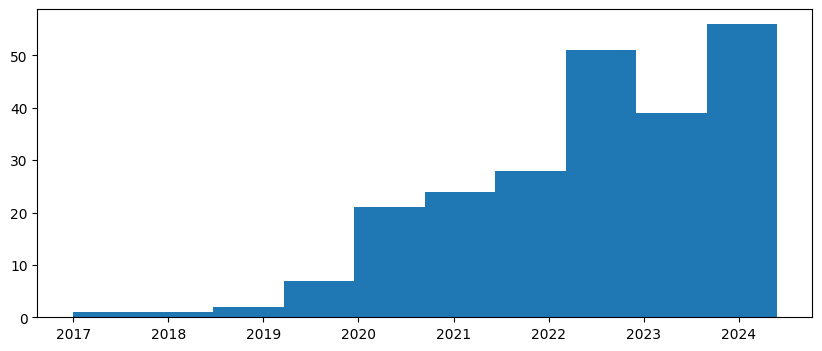

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.hist(query["data.created_utc"])
plt.show() 

In [13]:
def replies_data(children, thread):
    data={"name": children["data"]["name"],
          "thread": thread,
          "comment": children["data"]["body"],
          "reply": True,
          "score": children["data"]["score"]
         }
    #print(children["data"]["body"])
    return data

def comment_data(children, thread):
    data={"name": children["data"]["name"],
          "thread": thread,
          "comment": children["data"]["body"],
          "reply": False,
          "score": children["data"]["score"]
         }
    #print(children["data"]["body"])
    return data

def collect_more(link_id, children_links, all_data, thread, replyCount):
    for children_link in children_links:
        requestMore = requests.get(f"http://oauth.reddit.com/api/morechildren?link_id={link_id}&children={children_link}&api_type=json", headers=headers)
        requestMore = requestMore.json()
        #print(requestMore)
        for moreChildren in requestMore["json"]["data"]["things"]:
            if moreChildren["data"]["name"] != "t1__":
                if moreChildren["data"]["replies"] == "":
                    if replyCount == None:
                        all_data.append(comment_data(moreChildren, thread))
                        thread+=1
                    else:
                        all_data.append(replies_data(moreChildren, f"{thread}.{replyCount}"))
                        #print(f"{thread}.{replyCount}")
                        replyCount+=1
                else:
                    all_data.append(replies_data(moreChildren, f"{thread}.{replyCount}"))

                    repliesCursor = moreChildren["data"]["replies"]

                    collect_all_replies(repliesCursor, all_data, f"{thread}.{replyCount}", link_id)
            #else:
                #print("Empty moreChild :", moreChildren["data"]["children"])
        
def collect_all_replies(repliesCursor, all_data, thread, link_id):
    #Collect all replies of each comments
    replyCount=0
    for children in repliesCursor["data"]["children"]:
        #If the comment is not a moreChildren list
        if children["kind"] != "more":
            data = replies_data(children, f"{thread}.{replyCount}")
            #print(f"{thread}.{replyCount}")
            #print(children["data"]["body"])
            repliesCursor = children["data"]["replies"]
            
            #If there is replies to this comment
            if repliesCursor != "":
                collect_all_replies(repliesCursor , all_data, f"{thread}.{replyCount}", link_id)

            replyCount+=1
            all_data.append(data)
        else:
            children_links = children["data"]["children"]
            #print(link_id, children_links)
            
            collect_more(link_id, children_links, all_data, thread, replyCount)

In [14]:
def collect_comments(link_id):
    parent_id = ""
    children_links = ""
    
    all_data = []
    ComCount = 0
    
    params={#"limit":10000,
            #"threaded":True,
            #"sort":"new"
           }
    request = requests.get(f"https://oauth.reddit.com/comments/{link_id[3:]}", headers=headers)
    request = request.json()

    for first_children in request[1]["data"]["children"]:

        if first_children["kind"] != "more" and first_children["data"]["replies"] == "":
            all_data.append(comment_data(first_children, ComCount))

        elif first_children["kind"] != "more" and first_children["data"]["replies"] != "":
            all_data.append(replies_data(first_children, ComCount))

            repliesCursor = first_children["data"]["replies"]

            collect_all_replies(repliesCursor, all_data, ComCount, link_id)

        else:
            #parent_id = first_children["data"]["parent_id"]
            children_links = first_children["data"]["children"]
            #print(children_links)
            collect_more(link_id, children_links, all_data, ComCount, None)



        ComCount+=1
        #if first_children["data"]["replies"] not null 
        #print(first_children["data"]["replies"])
    return all_data

In [15]:
dfCom = pd.DataFrame(collect_comments("t3_128l6rd"))
dfCom

,name,thread,comment,reply,score
0,t1_jejbve6,0,“There’s a housing shortage!”\n\n“There’s too ...,True,830
1,t1_jenxvwq,0.0.0.0.0.0.0.0,"If it has to have an LA address, what I found ...",True,4
2,t1_jemxr25,0.0.0.0.0.0.0.1,And that’s if you’re lucky!,True,1
3,t1_jel6f96,0.0.0.0.0.0.0,And 400K might get you a tiny 1 bedroom condo,True,12
4,t1_jenxm3e,0.0.0.0.0.0.1,That's absolutely obnoxious.,True,2
...,...,...,...,...,...
897,t1_jeoazbd,356,I think it’s the moving back in with parents c...,False,1
898,t1_jel3ujj,357,"Jeez, come to the midwest. I’m just south of K...",False,1
899,t1_jel3zb2,358,Yeah. Right.,False,1
900,t1_jjqeyc8,359,Lol “lower rents”. Yeah right,False,1


In [16]:
for postId in query["data.name"]:
    postId = postId[3:]
    

In [17]:
!pip3 install contractions
!pip3 install num2words
!pip3 install nltk
!pip3 install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 4.2 MB/s eta 0:00:00


In [18]:
import string, re
import contractions
import num2words
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('wordnet2022')
nltk.download('omw-1.4')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

stop_words = nltk.corpus.stopwords.words("english")
stopwords_dict = Counter(stop_words)

! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # Manully unzip wordnet

lemmatizer = WordNetLemmatizer()

def wordnet_tag(word):
    #Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    
    #Tagging None tag words as noun has no incidence on the lemmatization
    #Alternative (tag, None) than you must exclude None tag words before lemmatizing
    return tag_dict.get(tag, wordnet.NOUN)

def textPreprocess(text):
    text = str(text)
    
    #replace number with words
    #text = re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), text)
    
    #replace contractions
    text = contractions.fix(text)
    
    #Lowecase
    text = text.lower()
    
    #replace \n, \xa0
    text = text.replace('\n',' ')
    #text = text.replace('\xa0',' ')
    
    # Removing punctuations in string
    text = re.sub(r'[^\w\s]', '', text)
    
    #remove whitespace
    text = " ".join(text.split())
    text = text.strip()
    
    #Tokenization
    text = nltk.word_tokenize(text)
    
    #remove Stopword
    text = [word for word in text if word not in stopwords_dict]
    
    #Lemmatization1
    text = [lemmatizer.lemmatize(word) for word in text]
    
    #Lemmatization2
    #text = [lemmatizer.lemmatize(word, wordnet_tag(word)) for word in text]
    
    return text

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [19]:
import time
start = time.time()
dfCom["Clean comment"] = dfCom["comment"].apply(textPreprocess)
end = time.time()
print("Time:", end - start)
dfCom

Time: 2.2590975761413574


,name,thread,comment,reply,score,Clean comment
0,t1_jejbve6,0,“There’s a housing shortage!”\n\n“There’s too ...,True,830,"[housing, shortage, much, housing, channeling,..."
1,t1_jenxvwq,0.0.0.0.0.0.0.0,"If it has to have an LA address, what I found ...",True,4,"[la, address, found, 640k, get, away, arleta, ..."
2,t1_jemxr25,0.0.0.0.0.0.0.1,And that’s if you’re lucky!,True,1,[lucky]
3,t1_jel6f96,0.0.0.0.0.0.0,And 400K might get you a tiny 1 bedroom condo,True,12,"[400k, might, get, tiny, 1, bedroom, condo]"
4,t1_jenxm3e,0.0.0.0.0.0.1,That's absolutely obnoxious.,True,2,"[absolutely, obnoxious]"
...,...,...,...,...,...,...
897,t1_jeoazbd,356,I think it’s the moving back in with parents c...,False,1,"[think, moving, back, parent, coupled, explosi..."
898,t1_jel3ujj,357,"Jeez, come to the midwest. I’m just south of K...",False,1,"[jeez, come, midwest, south, kansa, city, 3800..."
899,t1_jel3zb2,358,Yeah. Right.,False,1,"[yeah, right]"
900,t1_jjqeyc8,359,Lol “lower rents”. Yeah right,False,1,"[lol, lower, rent, yeah, right]"
